# Research Actions

This document is research of semantic similarity between including actions sentences from different documents. 

In [1]:
# import used modules
import os
import numpy as np
import time
import pickle

In [2]:
# import a model and a module for semantic analys
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../../model.bin', binary=True) 
model.init_sims(replace=True)

/home/ased/anaconda3/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
# import our module for semantic analys
import sys
sys.path.append('../../')
import sem_analysis as sa


Loading the model...
Processing input...


## 1. Extract Sentences From Documents And Their Preprocessing

In [9]:
files = dict()
for i in os.listdir():
    if os.path.isdir(i) and i.isdigit():
        for j in os.listdir(i):
            name = i + '/' + j
            f = open(name, 'r')
            files[i + '/' + j] = f.read()
            f.close()

In [17]:
import numpy as np
n = len(files.keys())
D = np.zeros((n, n))
keys = list(files.keys())
keys.sort()
texts = [files[i] for i in keys]
len(texts)

71

Now we transform our phrases to format for [RusVectores](https://rusvectores.org/ru/). See [tutorial for RusVectores](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb).

In [18]:
name_pickle = 'texts_transform.pickle'
if not name_pickle in os.listdir():
    t = time.time()
    texts_transform = list()
    for i in texts:
        texts_transform.append(sa.tag_ud(i))
        if len(texts_transform) % 10 == 0:
            print(len(texts_transform), time.time() - t)
    with open(name_pickle, 'wb') as f:
        pickle.dump(texts_transform, f)
        f.close()
else:
    with open(name_pickle, 'rb') as f: 
        texts_transform = pickle.load(f)
        f.close()

## 2. Similarity

### 2.1. Similarity withoud filtration

In [121]:
# Distance Matrix
import time
t = time.time()
for i in range(D.shape[0]):
    for j in range(i+1, D.shape[1]):
        if D[i, j] != np.inf:
            D[i,j] = model.wmdistance(texts_transform[i], texts_transform[j])
            D[j, i] = D[i, j]
            if i == 0 and j == 10:
                print((time.time() - t)/10*D.shape[0]*D.shape[0] * 0.9 * 0.5)

150.108639074564


#### Output

In [126]:
keys = list(files.keys())
keys.sort()
sim = dict()
for i in range(D.shape[0]):
    for j in range(i+1, D.shape[1]):
        if D[i,j] != np.inf and not np.isnan(D[i,j]):
            if not sim.__contains__(D[i,j]):
                sim[D[i,j]] = []
            sim[D[i,j]].append((keys[i], keys[j]))

In [127]:
keys = list(sim.keys())
keys.sort()

In [212]:
Q = [set([i]) for i in range(D.shape[0])]
def dist(set1, set2, D):
    s, k = 0, 0
    for i in set1:
        for j in set2:
            s += D[i, j]
            k += 1
    return s / k
def update(Q, D):
    m = None
    for i in Q:
        for j in Q:
            if i != j:
                cur = dist(i,j,D)
                if m is None or cur < m[2]:
                    m = (i, j, cur)
    new = set.union(m[0], m[1])
    Q.remove(m[0])
    Q.remove(m[1])
    Q.append(new)
    return Q
res = list()
res.append([set([names[j] for j in i]) for i in Q])
names = list(files.keys())
names.sort()
while len(Q) > 1:
    Q  = update(Q, D)
    res.append([set([names[j] for j in i]) for i in Q])

### Distance Distribution

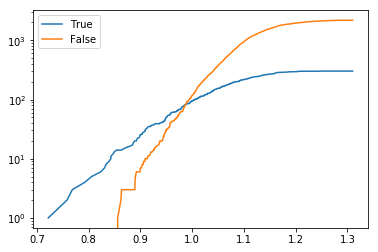

In [142]:
true, false = dict(), dict()
for i in keys:
    if i < 10:
        j = sim[i]
        true[i] = 0
        false[i] = 0
        for k in j:
            v1, v2 = k[0].split('/')[0], k[1].split('/')[0]
            iv1, iv2 = int(v1), int(v2)
            if (v1 == v2 or 
                (iv1 in [7,5] and iv2 in [7,5])or 
                (iv1 in [8,9] and iv2 in [8,9])):
                true[i] += 1
            else:
                false[i] += 1
                
import matplotlib.pylab as plt
% matplotlib inline
s1, s2 = 0, 0
x, y1, y2 =list(), list(), list()
for i in keys:
    s1 += true[i]
    s2 += false[i]
    x.append(i)
    y1.append(s1)
    y2.append(s2)
plt.semilogy(x, y1)
plt.semilogy(x, y2)
plt.legend(['True', 'False'])

## L2-norm

In [222]:
name_pickle = 'texts_transform.pickle'
with open(name_pickle, 'rb') as f: 
    texts_transform = pickle.load(f)
    f.close()
centers = list()
for j in texts_transform:
    new = [model[i] for i in j if model.__contains__(i)]
    centers.append(sum(new)/len(new))

In [225]:
names = list(files.keys())
names.sort()
list_ = [str(i) for i in range(1, 14)]
_ = [i.split('/')[0] for i in names]
cur_dict=dict()
for ind, i in enumerate(_):
    if not cur_dict.__contains__(i):
        cur_dict[i] = list()
    cur_dict[i].append(centers[ind])

In [227]:
spheres = dict()
for i in cur_dict:
    c = sum(cur_dict[i]) / len(cur_dict[i])
    spheres[i] = (c, max([np.linalg.norm(c - j) for j in cur_dict[i]]))

In [243]:
print([(i,spheres[i][1]) for i in spheres])
full_spheres = {i: list() for i in spheres}
for ind, j in enumerate(centers):
    m, r = None, np.inf
    for key in spheres:
        if m is None or r > np.linalg.norm(spheres[key][0] - j):
            m, r = key, np.linalg.norm(spheres[key][0] - j)
    full_spheres[m].append(ind)

[('4', 0.19749889), ('13', 0.0), ('6', 0.32385966), ('10', 0.27951425), ('7', 0.2962793), ('3', 0.1551227), ('12', 0.14154117), ('11', 0.23932087), ('1', 0.17428154), ('5', 0.20202908), ('2', 0.17635223), ('9', 0.19043814), ('8', 0.24444105)]


In [252]:
true_spheres = {i:[ind for ind,j in enumerate(names) if i ==j.split('/')[0]] for i in spheres}
def metric(list1, list2):
    TP = len([i for i in list2 if i in list1])
    FP = len([i for i in list2 if not i in list1])
    FN = len([i for i in list1 if not i in list2])
    return TP/(TP+FN), TP/(FP+TP)
def full_acc(true_spheres, full_spheres):
    s, fs = 0., 0.
    for i in true_spheres:
        s += len([j for j in full_spheres[i] if j in true_spheres[i]])
        fs += len(true_spheres[i])
    print(s/ fs)

keys = list(true_spheres.keys())
keys = [int(i) for i in keys]
keys.sort()
keys = [str(i) for i in keys]
for i in keys:
    print(i, metric(true_spheres[i], full_spheres[i]))
full_acc(true_spheres, full_spheres)

1 (1.0, 1.0)
2 (1.0, 1.0)
3 (1.0, 0.8)
4 (0.8571428571428571, 0.6666666666666666)
5 (0.6666666666666666, 0.75)
6 (0.8333333333333334, 0.8333333333333334)
7 (0.75, 0.8571428571428571)
8 (0.875, 0.875)
9 (0.8, 1.0)
10 (1.0, 1.0)
11 (1.0, 1.0)
12 (1.0, 1.0)
13 (1.0, 1.0)
0.8732394366197183
